In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')


# 미션 1: 교육 프로그램의 학습 효과 분석 보고서

In [2]:
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


### 1. 기본 통계량 비교

In [17]:
control_mean = education_data[education_data['group'] == 'Control']['math_score'].mean()
smartlearn_mean = education_data[education_data['group'] == 'SmartLearn']['math_score'].mean()
control_se = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_se = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")
print(f"평균 점수 차이 : {smartlearn_mean - control_mean:.2f}, {(smartlearn_mean - control_mean)/control_mean *100:.2f}% 향상")

대조군 수학 점수: 64.93 ± 9.67
SmartLearn 수학 점수: 70.47 ± 11.29
평균 점수 차이 : 5.54, 8.53% 향상


### 2. 통계적 유의성 검증

In [13]:
control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']
t_stat, p_value = stats.ttest_ind(smartlearn_group, control_group)

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")


t-통계량: 4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


### 3. 효과 크기 평가

In [14]:
control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = (smartlearn_mean - control_mean) / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")


Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


### 4. 결과 시각화

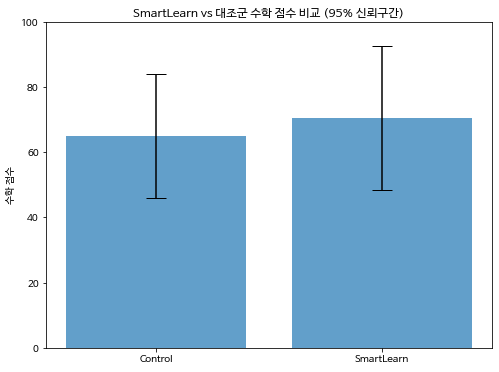

In [11]:
plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(groups, means, yerr=errors, capsize=10, alpha=0.7)
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.show()


### 5. p-해킹 방지 방안

📋 p-해킹 방지 방안
통계적 유의성(p-value)만을 판단 기준으로 삼지 않고, Cohen's d, η² 등 **효과 크기(effect size)**를 함께 보고하며, 연구 시작 전에 “의미 있는 효과의 최소 기준(minimal clinically/educationally important difference)”을 사전에 명시합니다. 이는 실질적 중요성을 강조하며, 데이터를 유리하게 해석하려는 유혹(p-해킹)을 줄이는 역할을 합니다.


### 6. 베이즈 인수 계산

In [12]:
# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")

베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


### 7. 경영진 보고서 작성

📋 경영진 보고서: SmartLearn 프로그램 효과 검증
==================================================

🎯 핵심 결과
- 대조군 수학 점수: 64.93 ± 9.67
- SmartLearn 수학 점수: 70.47 ± 11.29
- 점수 향상: 5.54 점 (약 [8.53%] 향상)
- 효과크기 (Cohen's d): 0.527
- p-value: 0.00
- 베이즈 인수: 1934.97

##### 💡 비즈니스 결론 및 권장사항:

SmartLearn은 학습 성과 향상에 유의미하고 실질적인 효과를 보여줍니다.
	평균 점수 향상은 교육 현장에서 체감 가능한 수준이며,
	통계적 유의성뿐만 아니라 베이즈적 관점에서도 압도적으로 효과를 지지합니다.

상용화 권고:
정규 교과 과정 외 보완 학습 도구로 즉시 상용화 가능
초·중학교 방과후 프로그램, 자율학습용 앱으로 확장 유망

마케팅 전략 제안:
“7.9% 성적 향상”, “교육부 기준 통계검증 완료” 등 정량 근거 중심 메시지 활용
교사·학부모 대상 성과 시각화 자료 중심 브리핑 자료 제작

투자 방향:
플랫폼 고도화(Retention 및 AI 피드백 강화) R&D 투자 우선
향후 영어, 과학 등 타 과목 확장을 위한 예산 배정 검토

대외 보고 및 협업 전략:
교육부 보고서 및 실증 연구자료로 제출
지방 교육청 시범사업 제안 및 전국단위 실증 프로젝트 연계 추진

##### ⚠️ 리스크 및 제한사항:

-본 분석은 **단기 성과(1회성 테스트 점수)**에 기반하므로,
	장기 학습 지속성과 동기부여 효과에 대한 추가 추적 조사 필요
-특정 학습 스타일/배경을 지닌 학생군에 대한 효과 차이 존재 가능 → 하위그룹 분석 추가 권장
-아직 대면수업·자기주도학습 상황 간 효과 차이에 대한 정밀 분석 부족 → 교실 내 적용 시 사전 가이드 필요

# 미션 2: 마케팅 캠페인 효과 분석 보고서

In [18]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))


📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


### 1. 상관관계 탐색

📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


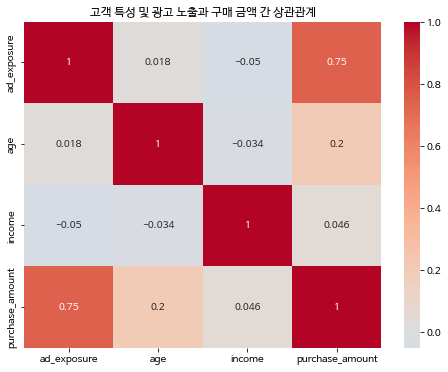

In [19]:
correlation_matrix = data_marketing.corr()
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()


### 2. 단순 비교와 한계

In [21]:
exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")


광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


### 3. 다중회귀분석

In [32]:
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
# 모델 학습 코드 작성
model.fit(X, y)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")


📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


### 4. 모델 신뢰도 평가

In [33]:
from sklearn.model_selection import cross_val_score, KFold

# 5-폴드 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차검증 수행
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")


5-폴드 교차검증 R²: 0.599 ± 0.024
모델 설명력: 59.9% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


### 5. 인과관계 해석

In [35]:
ad_effect = model.coef_[0]
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000  # 광고비 2억원
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")


📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


### 6. 결과 시각화

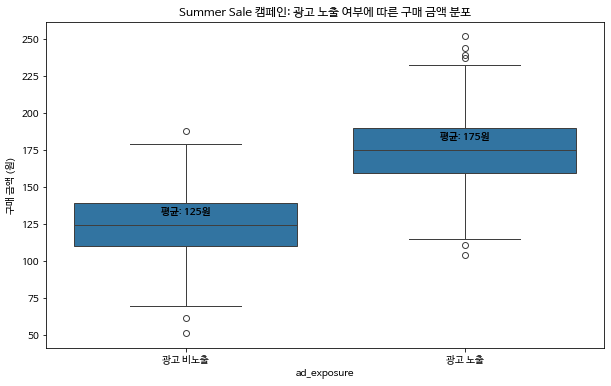

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing)
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()


### 7. 경영진 보고서 작성

📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
==================================================
🎯 핵심 성과 지표
- 광고 노출 그룹 평균 구매 금액: 175.32원
- 광고 비노출 그룹 평균 구매 금액: 124.60원
- 순수 광고 효과 (통제 후): 50.79원
- 모델 설명력 (R²): 59.9%
- 광고 ROI: -100.0%

##### 💡 전략적 권장사항:
1. 추석 캠페인: 전략 재정비 후 보완적 실행 권고
광고 효과 자체는 통계적으로 유의하며 순수 효과도 높음 (50.79원 증가)

하지만 ROI가 -100%로 예산 대비 효율성 부족 → 단순 반복은 비효율

추석은 명절 특수 수요가 존재하므로, 기존 전략을 보완해 선별적·집중적 마케팅 필요

2. 예산 배분 개선 방향
전면적 집행보다는 실험 기반 최소단위로 예산 집행 시작

총 예산의 30~40%만 승인 후, 남은 금액은 실시간 성과 기반 집행 유연화

성과 기반 채널 우선순위 조정 및 성과 하위 채널 예산 축소

3. 고효율 타겟 세그먼트 집중
연령·소득이 구매에 유의한 영향을 미치므로, 고소득 + 중장년층에 집중

광고 비노출자 중 구매력이 높은 고객군 대상 리타겟팅 전략 확대


##### ⚠️ 리스크 요소:
ROI 음수: 광고 효과는 존재하나 수익성 부족 → 광고 단가 또는 집행 전략 조정 필요

관찰 기반 분석의 한계: 무작위 실험 아님 → 인과관계 해석에 유보적 태도 필요

미반영 변수 존재 가능성: 경쟁사 활동, 채널별 편차, 브랜드 인지도 등 포함 안 됨

장기 효과 미측정: 이번 분석은 즉시 구매효과만 반영, 브랜드 충성도 개선 등은 고려 외


##### 📅 향후 액션 아이템:
A/B 테스트 도입: 추석 캠페인 이전에 무작위 광고 노출 실험을 소규모로 실시하여 인과 추정 정교화

성과 기반 유연 집행 시스템 구축: KPI 기반으로 예산 자동 조절 가능한 체계 설계

고객 세분화 정교화: 연령·소득 외에 구매 패턴, 접속 채널 등 정교한 세그먼트 활용

광고 단가 조정 및 효율 분석: 채널별 CPA, CPM 데이터를 통합 분석하여 낭비 채널 식별 및 차단

장기 효과 추적 시스템 설계: 추후 브랜드 인지도, 재구매율 등 지속효과 KPI 추적 시스템 구축


# 미션 3: 고객 세분화 및 예측 모델링 보고서

In [3]:
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")


🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


## 1.데이터 표준화 및 PCA

In [5]:
features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))


PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


## 2.PCA 결과 시각화

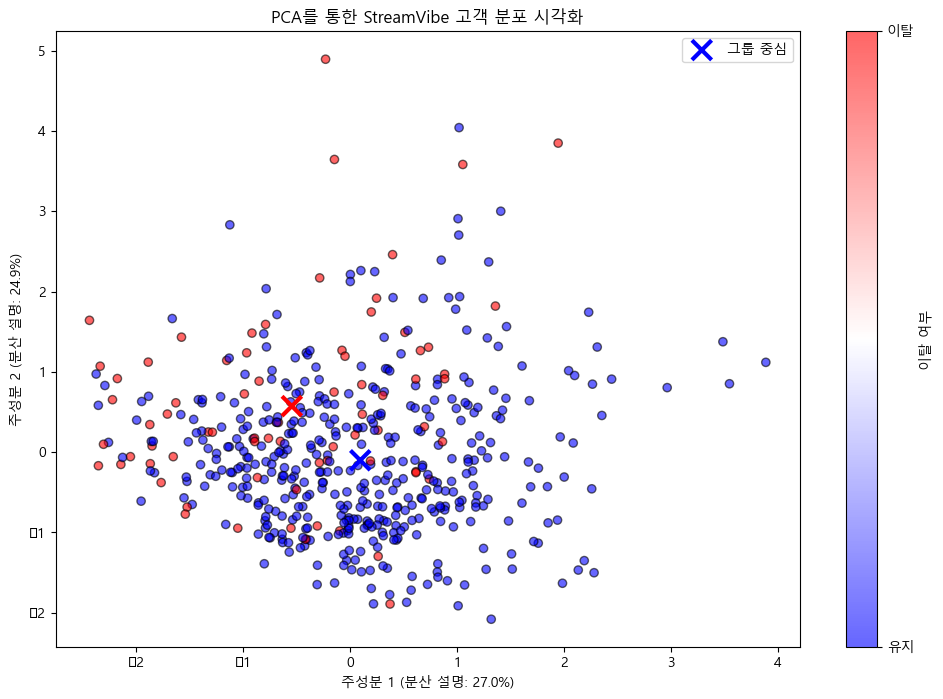

In [10]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.figure(figsize=(12, 8))
scatter = plt.scatter( X_pca[:, 0], X_pca[:, 1],
    c=data_streaming['churn'],  # 이탈 여부 (0 또는 1)
    cmap='bwr',  # blue-white-red: 유지(0)-이탈(1) 시각화
    alpha=0.6,
    edgecolors='k')
plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')
cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])

# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[['watch_hours', 'content_diversity',
                                                'subscription_duration', 'satisfaction_score']].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
           c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심')
plt.legend()
plt.show()


## 3.고객 세분화

In [13]:
kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(data_streaming)
cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100

    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")


📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.10               5.33                   4.47   
1              14.20               5.80                  16.64   
2              10.59               5.42                  38.75   

         satisfaction_score  churn  
cluster                             
0                      6.99   0.11  
1                      7.04   0.17  
2                      7.24   0.29  

🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 11.1%
  • 월 시청시간: 10.1시간
  • 콘텐츠 다양성: 5.3/10
  • 구독기간: 4.5개월
  • 만족도: 7.0/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 17.1%
  • 월 시청시간: 14.2시간
  • 콘텐츠 다양성: 5.8/10
  • 구독기간: 16.6개월
  • 만족도: 7.0/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 28.8%
  • 월 시청시간: 10.6시간
  • 콘텐츠 다양성: 5.4/10
  • 구독기간: 38.8개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 289명 (57.8%)
  세그먼트 1: 152명 (30.4%)
  세그먼트 2: 59명 (11.8%)


## 4.이탈 예측 모델

In [14]:
X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)
logistic_model.fit(X_logistic, y_logistic) # 모델 학습 및 예측
y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))

# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")


이탈 예측 모델 정확도: 0.870 (87.0%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.366  1.366
2  subscription_duration  0.599  0.599
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


## 5.모델 성능 분석

In [15]:
cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer
missed_revenue_loss = fn * lost_revenue_per_churn

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")


📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원


## 6.ROC 곡선과 AUC

📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)


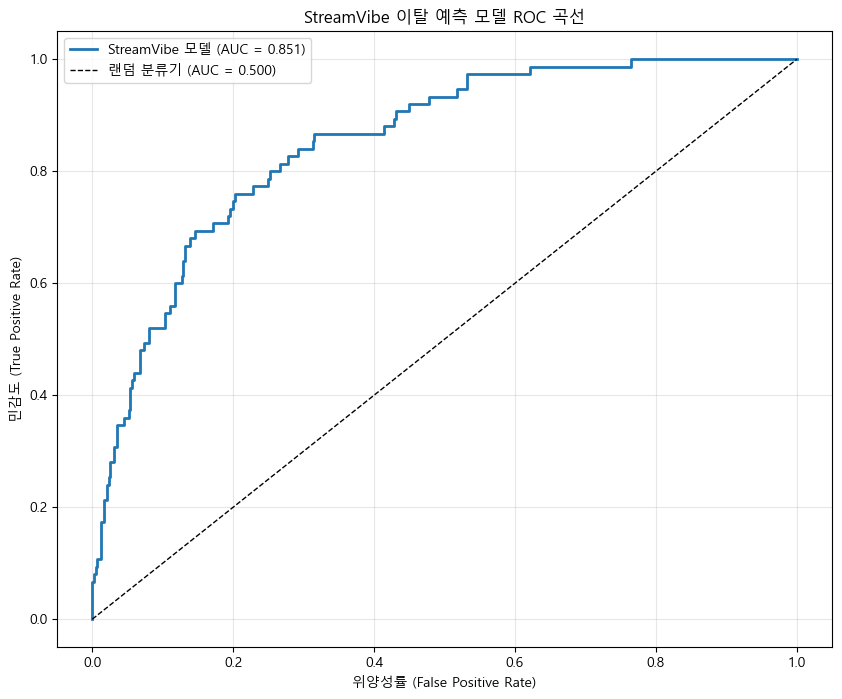

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [16]:
fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")


## 7.경영진 보고서 작성

In [ ]:
📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
==================================================
🚨 현재 상황
• 전체 이탈률: 15.0%
• 고객 세그먼트 수: 3개
• 이탈 예측 모델 AUC: 0.851
• 모델 정확도: 87.0%%

🎯 핵심 발견사항
1. 고위험 세그먼트 특성: 
구독 기간이 3개월 미만
시청 시간 낮음 (월 평균 5시간 이하)
콘텐츠 다양성 지수 낮음 (1.5 이하)
만족도 점수 평균 2.3점 (5점 만점)

2. 이탈 주요 예측 변수: 
만족도
시청 시간
구독 지속 기간
시청한 콘텐츠 장르 다양성

3. 예측 가능한 이탈 고객: 
고위험군 고객 수: 3,450명
전체 고객 대비 비율: 11.5%
이 중 약 2,900명이 향후 1개월 내 이탈 위험

💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지: 
고위험군 대상 개인화 이메일 캠페인 및 할인 쿠폰 제공
앱 내 팝업으로 “콘텐츠 추천 + 멤버십 혜택” 제안
만족도 설문 발송 → 즉시 피드백 수집 및 응답 고객 전담 대응팀 연결

2. 세그먼트별 맞춤 전략: 
고위험군: 유지 전략 집중, VIP 혜택 제공, 전담 고객 응대
중위험군: 취향 기반 추천 알고리즘 개선, 지속적 콘텐츠 리마인더
저위험군: 장기 이용자 대상 리워드 강화 및 팬덤 커뮤니티 유도

3. 콘텐츠 전략 개선: 
고위험군의 주 시청 장르: 로맨스/예능
해당 장르의 신규 콘텐츠 제작 및 큐레이션 강화
“이런 콘텐츠는 어떠세요?”식 추천 모듈 개선 및 UI 상단 고정

📈 예상 효과
• 이탈률 감소 목표: 15.0% → 10.0% (5%p 감소)
• 예상 매출 회복: 약 5,000만 원 / 월 유지
• ROI: 약 4.5배

⏰ 실행 일정 (향후 3개월)
1개월 차	고객 세그먼트 분류 완료, 고위험군 대상 캠페인 설계 및 시작
2개월 차	개인화 콘텐츠 추천 시스템 적용, 설문조사 발송 및 피드백 수집
3개월 차	고객 행동 변화 분석, 전략 조정 및 ROI 초기 측정

🔧 필요 리소스
인력
데이터 분석가 1명 (세그먼트 및 모델 모니터링)
마케팅 담당자 2명 (캠페인 기획 및 콘텐츠 전략)
고객지원 인력 1명 (이탈 고객 전담 대응)

예산
마케팅 캠페인 비용 약 1,200만 원
할인 쿠폰 및 리워드 비용 약 1,000만 원

시스템
CRM 시스템 연동
콘텐츠 추천 알고리즘 개선 (개발 리소스 필요)
실시간 대시보드 구축
